## **NAMA: Sharon Zefanya Setiawan**
## **NIM: 2501961022**
## **KELAS: LA09**

### 2.  DJ Patil dikenal sebagai data scientist yang pertama kali. Tugasnya adalah menganalisis maha data untuk diubah menjadi informasi yang bermanfaat dan membuat program serta algoritma untuk membantu perusahaan beroperasi dengan optimal. Ia ingin memperbaiki model prediksi harga saham dengan menggunakan algoritma **Transformers.** Anda diminta untuk membantu DJ Patil dalam melakukan perbaikan ini.


**DATASET B**

Dataset ini berisi harga harian historis untuk beberapa saham sektor teknologi:

1.   Amazon.com, Inc (AMZN)
2.   Cisco Systems, Inc (CSCO)



#### a. Lakukan **praproses data** dengan **memisahkan data time series tersebut menjadi dua bagian input dan output dengan window size = 5 [dari hari senin s.d jumat] dan horizon = 5 [dari hari senin s.d jumat].** Kemudian pisahkan dataset menjadi 80% training set, 10% validation set dan 10% test set.


In [185]:
# import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import requests

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, LSTM, Dense, Dropout
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime

##### **AMAZON DATASET**

In [186]:
# read data
df_amzn = pd.read_csv('https://raw.githubusercontent.com/sharonzefanyaa/UAS-deeplearn/main/Dataset%20B/AMZN.csv',
                      parse_dates=["Date"],
                      index_col=["Date"])
df_amzn.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [187]:
df_amzn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5758 entries, 1997-05-15 to 2020-04-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5758 non-null   float64
 1   High       5758 non-null   float64
 2   Low        5758 non-null   float64
 3   Close      5758 non-null   float64
 4   Adj Close  5758 non-null   float64
 5   Volume     5758 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 314.9 KB


In [188]:
df_amzn.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5758.000000,5758.000000,5758.000000,5758.000000,5758.000000,5.758000e+03
mean,340.458153,344.156408,336.344390,340.417580,340.417580,7.556094e+06
std,523.365374,528.138556,517.726971,523.140207,523.140207,7.325904e+06
min,1.406250,1.447917,1.312500,1.395833,1.395833,4.872000e+05
25%,37.460001,38.334999,36.812499,37.562500,37.562500,3.685525e+06
50%,81.965000,83.520000,79.875000,81.599998,81.599998,5.692450e+06
75%,335.267494,337.537491,331.727501,334.290001,334.290001,8.594350e+06
max,2173.070068,2185.949951,2161.120117,2170.219971,2170.219971,1.043292e+08


In [189]:
df_amzn.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [190]:
df_amzn.duplicated().sum()


0

In [191]:
# only closing price
amzn_price = pd.DataFrame(df_amzn["Close"]).rename(columns={"Close": "Price"})
amzn_price.head()

,Price
Date,
1997-05-15,1.958333
1997-05-16,1.729167
1997-05-19,1.708333
1997-05-20,1.635417
1997-05-21,1.427083


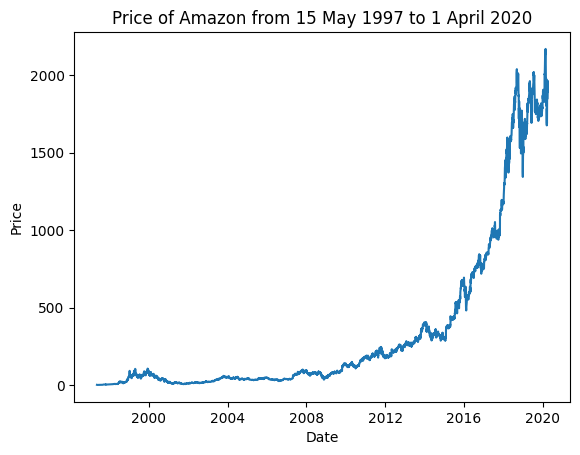

<Figure size 1200x1000 with 0 Axes>

In [192]:
sns.lineplot(data=amzn_price, x="Date", y="Price")
plt.title("Price of Amazon from 15 May 1997 to 1 April 2020")
plt.figure(figsize=(12,10))
plt.show()

Dari hasil eksplorasi data sekilas di atas, diketahui bahwa data sudah siap untuk diproses lebih lanjut. Sebelumnya, atribut 'Date' sudah diubah menjadi index dengan format data datetime, tidak ada missing value maupun duplikasi data yang mencurigakan.

In [193]:
# get date array
timesteps1 = amzn_price.index.to_numpy()
prices1 = amzn_price["Price"].to_numpy()

timesteps1[:10], prices1[:10]

(array(['1997-05-15T00:00:00.000000000', '1997-05-16T00:00:00.000000000',
        '1997-05-19T00:00:00.000000000', '1997-05-20T00:00:00.000000000',
        '1997-05-21T00:00:00.000000000', '1997-05-22T00:00:00.000000000',
        '1997-05-23T00:00:00.000000000', '1997-05-27T00:00:00.000000000',
        '1997-05-28T00:00:00.000000000', '1997-05-29T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([1.95833337, 1.72916663, 1.70833337, 1.63541663, 1.42708337,
        1.39583337, 1.5       , 1.58333337, 1.53125   , 1.50520837]))

In [194]:
def basic_splits(timesteps, prices):
    train_size = int(0.8 * len(prices)) # 80% train
    val_size = int(0.1 * len(prices)) # 10% validation

    X_train, Y_train = timesteps[:train_size], prices[:train_size]
    X_val, Y_val = timesteps[train_size:train_size+val_size], prices[train_size:train_size+val_size]
    X_test, Y_test = timesteps[train_size+val_size:], prices[train_size+val_size:]

    return X_train, X_val, X_test, Y_train, Y_val, Y_test

In [195]:
X_train1, X_val1, X_test1, Y_train1, Y_val1, Y_test1= basic_splits(timesteps1, prices1)
print("Train set length:", len(X_train1))
print("Validation set length:", len(X_val1))
print("Test set length:", len(X_test1))
print("Train labels length:", len(Y_train1))
print("Validation labels length:", len(Y_val1))
print("Test labels length:", len(Y_test1))

Train set length: 4606
Validation set length: 575
Test set length: 577
Train labels length: 4606
Validation labels length: 575
Test labels length: 577


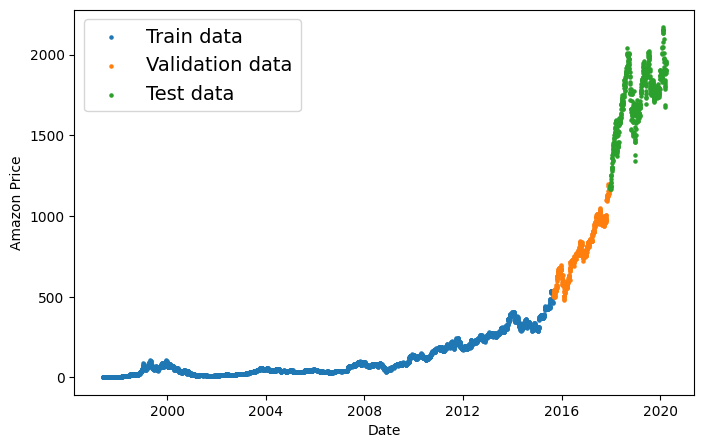

In [196]:
# plot correctly made splits
plt.figure(figsize=(8, 5))
plt.scatter(X_train1, Y_train1, s=5, label="Train data")
plt.scatter(X_val1, Y_val1, s=5, label="Validation data")
plt.scatter(X_test1, Y_test1, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Amazon Price")
plt.legend(fontsize=14)
plt.show();

In [197]:
def build_windows(data, window_size, horizon):
    windows = []
    labels = []
    for i in range(len(data) - window_size - horizon + 1):
        windows.append(data[i:i+window_size])
        labels.append(data[i+window_size+horizon-1])
    return np.array(windows), np.array(labels)

In [198]:
WINDOW_SIZE = 5
HORIZON = 5

In [199]:
full_windows1, full_labels1 = build_windows(prices1, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows1), len(full_labels1)

(5749, 5749)

In [200]:
def train_val_test_splits(windows, labels):
    train_size = int(0.8 * len(windows)) # 80% train
    val_size = int(0.1 * len(windows)) # 10% validation

    train_windows, train_labels = windows[:train_size], labels[:train_size]
    val_windows, val_labels = windows[train_size:train_size+val_size], labels[train_size:train_size+val_size]
    test_windows, test_labels = windows[train_size+val_size:], labels[train_size+val_size:]

    return train_windows, val_windows, test_windows, train_labels, val_labels, test_labels

In [201]:
train_windows1, val_windows1, test_windows1, train_labels1, val_labels1, test_labels1= train_val_test_splits(full_windows1, full_labels1)
print("Train set length:", len(train_windows1))
print("Validation set length:", len(val_windows1))
print("Test set length:", len(test_windows1))
print("Train labels length:", len(train_labels1))
print("Validation labels length:", len(val_labels1))
print("Test labels length:", len(test_labels1))

Train set length: 4599
Validation set length: 574
Test set length: 576
Train labels length: 4599
Validation labels length: 574
Test labels length: 576


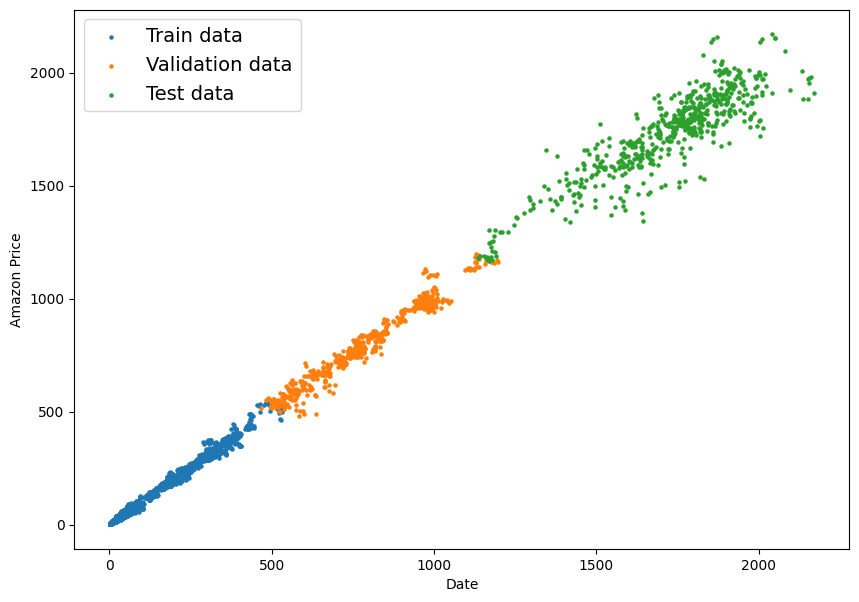

In [202]:
# plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(train_windows1[:,0], train_labels1, s=5, label="Train data")
plt.scatter(val_windows1[:,0], val_labels1, s=5, label="Validation data")
plt.scatter(test_windows1[:,0], test_labels1, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Amazon Price")
plt.legend(fontsize=14)
plt.show()

In [203]:
# check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels1[:-HORIZON-1]), Y_train1[WINDOW_SIZE:])

False

Menurut hasil pencocokkan di atas, diketahui bahwa adanya ketidakcocokan nilai pada target yang diprediksi. Hal ini dapat terjadi karena adanya pergeseran input & output ketika menggunakan windowing, yang akhirnya menyebabkan perbedaan antara target aktual dan prediksi model. Dapat dilihat bahwa jumlah training sebelum windowing (4606) tidak jauh berbeda dengan jumlah training setelah windowing (4599). Plotting yang dihasilkan setelah windowing juga memberikan kesimpulan bahwa setiap data training, validation, dan test set masih tersusun dengan baik. Oleh karena itu, menurut saya, hal ini masih dapat ditoleransi karena pergeseran yang terjadi masih termasuk pergeseran kecil dan dampaknya teradap kinerja model secara keseluruhan tidak signifikan.

In [204]:
print("Train Set:", train_windows1.shape)
print("Validation Set:", val_windows1.shape)
print("Test Set:", test_windows1.shape)

Train Set: (4599, 5)
Validation Set: (574, 5)
Test Set: (576, 5)


Dengan mencetak jumlah baris dan kolom dalam setiap set data, dapat memudahkan saya untuk melihat ukuran atau dimensi dari setiap set data tersebut, yang dapat memberikan gambaran tentang seberapa besar atau kecilnya data yang digunakan untuk melatih, menguji, dan memvalidasi model pembelajaran mesin.

In [205]:
mm = MinMaxScaler(feature_range=(0, 1))
training_set_scaled1 = mm.fit_transform(train_windows1)
test_set_scaled1 = mm.transform(test_windows1)
val_set_scaled1 = mm.transform(val_windows1)

training_set_scaled_labels1 = mm.fit_transform(train_labels1.reshape(-1, 1))
test_set_scaled_labels1 = mm.transform(test_labels1.reshape(-1, 1))
val_set_scaled_labels1 = mm.transform(val_labels1.reshape(-1, 1))

Tujuan dari melakukan scaling dengan MinMaxScaler adalah untuk mengubah rentang nilai data menjadi antara 0 dan 1. Dengan menggunakan MinMaxScaler dan mengubah rentang data menjadi antara 0 dan 1, saya ingin memastikan bahwa data siap digunakan dalam model pembelajaran dan mengurangi potensi masalah yang terkait dengan perbedaan skala.

In [206]:
timesteps = 8

x_train1 = []
y_train1 = []

x_val1 = []
y_val1 = []

x_test1 = []
y_test1 = []

for i in range(timesteps,train_windows1.shape[0]):
    x_train1.append(training_set_scaled1[i-timesteps:i,0])
    y_train1.append(training_set_scaled1[i,0])
x_train1, y_train1 = np.array(x_train1), np.array(y_train1)

for i in range(timesteps,val_windows1.shape[0]):
    x_val1.append(val_set_scaled1[i-timesteps:i,0])
    y_val1.append(val_set_scaled1[i,0])
x_val1, y_val1 = np.array(x_val1), np.array(y_val1)

for i in range(timesteps,test_windows1.shape[0]):
    x_test1.append(test_set_scaled1[i-timesteps:i,0])
    y_test1.append(test_set_scaled1[i,0])
x_test1, y_test1 = np.array(x_test1), np.array(y_test1)

print(x_train1[0], y_train1[0])
print(x_train1[1], y_train1[1])

print(x_val1[0], y_val1[0])
print(x_val1[1], y_val1[1])

print(x_test1[0], y_test1[0])
print(x_test1[1], y_test1[1])

[1.05019625e-03 6.22338371e-04 5.83442362e-04 4.47305662e-04
 5.83442362e-05 0.00000000e+00 1.94480713e-04 3.50065417e-04] 0.00025282494918691095
[6.22338371e-04 5.83442362e-04 4.47305662e-04 5.83442362e-05
 0.00000000e+00 1.94480713e-04 3.50065417e-04 2.52824949e-04] 0.0002042048265724736
[0.86811399 0.93233932 0.9651988  0.9645267  0.95496759 0.92444188
 0.95059873 0.93971405] 0.9290347204369602
[0.93233932 0.9651988  0.9645267  0.95496759 0.92444188 0.95059873
 0.93971405 0.92903472] 0.9636491478447883
[2.11449616 2.12872281 2.14884929 2.16274    2.16686603 2.17978586
 2.17261636 2.17084279] 2.1897556638473947
[2.12872281 2.14884929 2.16274    2.16686603 2.17978586 2.17261636
 2.17084279 2.18975566] 2.1988667088829836


In [207]:
print("Train Shape : ")
print(x_train1.shape, y_train1.shape)
x_train1 = x_train1.reshape((x_train1.shape[0], x_train1.shape[1], 1))
print(x_train1.shape, y_train1.shape)
print("")

print("Val Shape : ")
print(x_val1.shape, y_val1.shape)
x_val1 = x_val1.reshape((x_val1.shape[0], x_val1.shape[1], 1))
print(x_val1.shape, y_val1.shape)
print("")

print("Test Shape : ")
print(x_test1.shape, y_test1.shape)
x_test1 = x_test1.reshape((x_test1.shape[0], x_test1.shape[1], 1))
print(x_test1.shape, y_test1.shape)
print("")

Train Shape : 
(4591, 8) (4591,)
(4591, 8, 1) (4591,)

Val Shape : 
(566, 8) (566,)
(566, 8, 1) (566,)

Test Shape : 
(568, 8) (568,)
(568, 8, 1) (568,)



##### **CISCO DATASET**

In [208]:
# read data
df_csco = pd.read_csv('https://raw.githubusercontent.com/sharonzefanyaa/UAS-deeplearn/main/Dataset%20B/CSCO.csv',
                      parse_dates=["Date"],
                      index_col=["Date"])
df_csco.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-02-16,0.0,0.079861,0.073785,0.077257,0.059806,940636800
1990-02-20,0.0,0.079861,0.074653,0.079861,0.061822,151862400
1990-02-21,0.0,0.078993,0.075521,0.078125,0.060478,70531200
1990-02-22,0.0,0.081597,0.078993,0.078993,0.061150,45216000
1990-02-23,0.0,0.079861,0.078125,0.078559,0.060814,44697600


In [209]:
df_csco.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7589 entries, 1990-02-16 to 2020-04-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       7589 non-null   float64
 1   High       7589 non-null   float64
 2   Low        7589 non-null   float64
 3   Close      7589 non-null   float64
 4   Adj Close  7589 non-null   float64
 5   Volume     7589 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 415.0 KB


In [210]:
df_csco.describe()

,Open,High,Low,Close,Adj Close,Volume
count,7589.000000,7589.000000,7589.000000,7589.000000,7589.000000,7.589000e+03
mean,20.404527,20.682047,20.116294,20.399541,16.945200,5.680188e+07
std,14.915392,15.133191,14.676149,14.906589,13.253297,4.168727e+07
min,0.000000,0.072917,0.068576,0.071181,0.055102,8.064000e+05
25%,8.444445,8.583333,8.326389,8.479167,6.563846,3.245060e+07
50%,19.700001,19.937500,19.440001,19.680000,15.311988,4.898850e+07
75%,27.129999,27.410000,26.830000,27.120001,21.845076,6.822650e+07
max,81.437500,82.000000,79.062500,80.062500,61.977535,9.406368e+08


In [211]:
df_csco.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [212]:
df_csco.duplicated().sum()

0

In [213]:
# only closing price
csco_price = pd.DataFrame(df_csco["Close"]).rename(columns={"Close": "Price"})
csco_price.head()

,Price
Date,
1990-02-16,0.077257
1990-02-20,0.079861
1990-02-21,0.078125
1990-02-22,0.078993
1990-02-23,0.078559


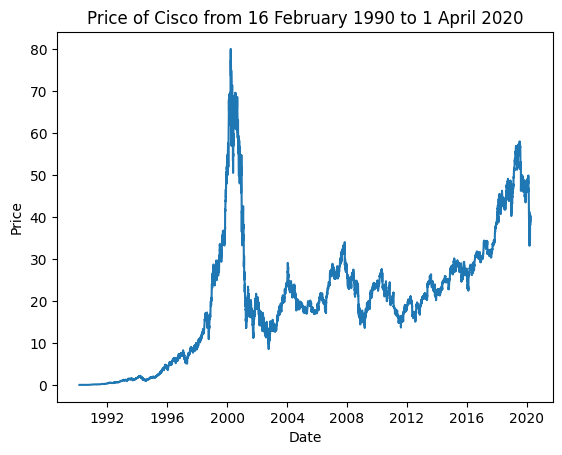

<Figure size 1200x1000 with 0 Axes>

In [214]:
sns.lineplot(data=csco_price, x="Date", y="Price")
plt.title("Price of Cisco from 16 February 1990 to 1 April 2020")
plt.figure(figsize=(12,10))
plt.show()

Dari hasil eksplorasi data sekilas di atas, diketahui bahwa data sudah siap untuk diproses lebih lanjut. Sebelumnya, atribut 'Date' sudah diubah menjadi index dengan format data datetime, tidak ada missing value maupun duplikasi data yang mencurigakan.

In [215]:
# get date array
timesteps2 = csco_price.index.to_numpy()
prices2 = csco_price["Price"].to_numpy()

timesteps2[:10], prices2[:10]

(array(['1990-02-16T00:00:00.000000000', '1990-02-20T00:00:00.000000000',
        '1990-02-21T00:00:00.000000000', '1990-02-22T00:00:00.000000000',
        '1990-02-23T00:00:00.000000000', '1990-02-26T00:00:00.000000000',
        '1990-02-27T00:00:00.000000000', '1990-02-28T00:00:00.000000000',
        '1990-03-01T00:00:00.000000000', '1990-03-02T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([0.07725695, 0.07986111, 0.078125  , 0.07899305, 0.07855903,
        0.07638889, 0.078125  , 0.08072916, 0.07986111, 0.08072916]))

In [216]:
X_train2, X_val2, X_test2, Y_train2, Y_val2, Y_test2= basic_splits(timesteps2, prices2)
print("Train set length:", len(X_train1))
print("Validation set length:", len(X_val1))
print("Test set length:", len(X_test1))
print("Train labels length:", len(Y_train1))
print("Validation labels length:", len(Y_val1))
print("Test labels length:", len(Y_test1))

Train set length: 4606
Validation set length: 575
Test set length: 577
Train labels length: 4606
Validation labels length: 575
Test labels length: 577


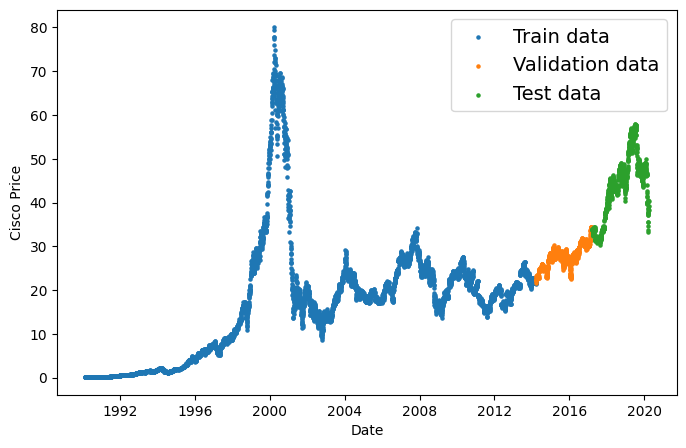

In [217]:
# plot correctly made splits
plt.figure(figsize=(8, 5))
plt.scatter(X_train2, Y_train2, s=5, label="Train data")
plt.scatter(X_val2, Y_val2, s=5, label="Validation data")
plt.scatter(X_test2, Y_test2, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Cisco Price")
plt.legend(fontsize=14)
plt.show();

In [218]:
WINDOW_SIZE = 5
HORIZON = 5

In [219]:
full_windows2, full_labels2 = build_windows(prices2, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows2), len(full_labels2)

(7580, 7580)

In [220]:
train_windows2, val_windows2, test_windows2, train_labels2, val_labels2, test_labels2= train_val_test_splits(full_windows2, full_labels2)
print("Train set length:", len(train_windows2))
print("Validation set length:", len(val_windows2))
print("Test set length:", len(test_windows2))
print("Train labels length:", len(train_labels2))
print("Validation labels length:", len(val_labels2))
print("Test labels length:", len(test_labels2))

Train set length: 6064
Validation set length: 758
Test set length: 758
Train labels length: 6064
Validation labels length: 758
Test labels length: 758


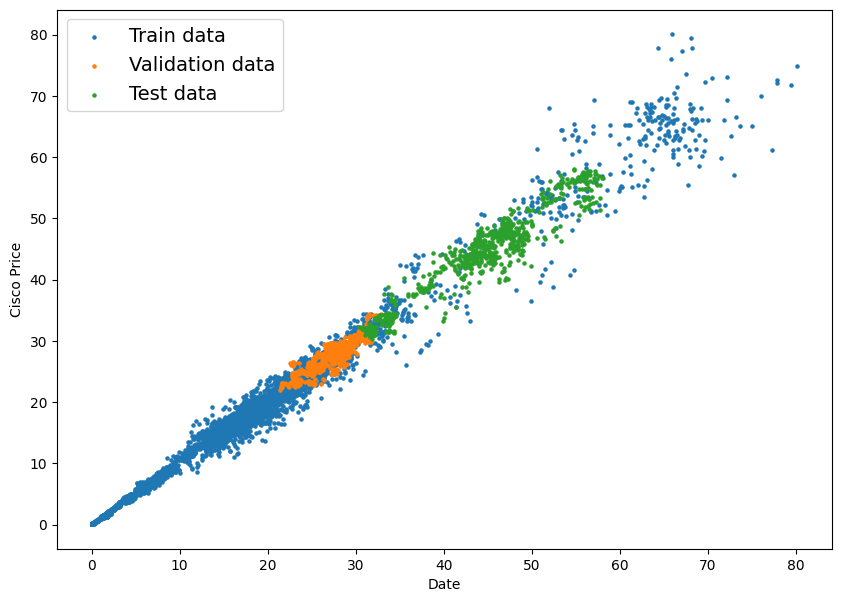

In [221]:
# plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(train_windows2[:,0], train_labels2, s=5, label="Train data")
plt.scatter(val_windows2[:,0], val_labels2, s=5, label="Validation data")
plt.scatter(test_windows2[:,0], test_labels2, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Cisco Price")
plt.legend(fontsize=14)
plt.show()

In [222]:
# check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels2[:-HORIZON-1]), Y_train2[WINDOW_SIZE:])

False

Menurut hasil pencocokkan di atas, diketahui bahwa adanya ketidakcocokan nilai pada target yang diprediksi. Hal ini dapat terjadi karena adanya pergeseran input & output ketika menggunakan windowing, yang akhirnya menyebabkan perbedaan antara target aktual dan prediksi model. Dapat dilihat bahwa jumlah training sebelum windowing (4606)  berbeda cukup jauh dengan jumlah training setelah windowing (6064). Bahkan, melalui plotting setelah windowing, dapat dilihat juga adanya training data yang tersebar jauh dari yang seharusnya. Menurut saya, hal ini dapat cukup mengganggu karena pergeseran yang terjadi termasuk pergeseran yang dapat berdampak terhadap kinerja model secara keseluruhan tidak signifikan.

In [223]:
print("Train Set:", train_windows2.shape)
print("Validation Set:", val_windows2.shape)
print("Test Set:", test_windows2.shape)

Train Set: (6064, 5)
Validation Set: (758, 5)
Test Set: (758, 5)


Dengan mencetak jumlah baris dan kolom dalam setiap set data, dapat memudahkan saya untuk melihat ukuran atau dimensi dari setiap set data tersebut, yang dapat memberikan gambaran tentang seberapa besar atau kecilnya data yang digunakan untuk melatih, menguji, dan memvalidasi model pembelajaran mesin.

In [224]:
mm = MinMaxScaler(feature_range=(0, 1))
training_set_scaled2 = mm.fit_transform(train_windows2)
test_set_scaled2 = mm.transform(test_windows2)
val_set_scaled2 = mm.transform(val_windows2)

training_set_scaled_labels2 = mm.fit_transform(train_labels2.reshape(-1, 1))
test_set_scaled_labels2 = mm.transform(test_labels2.reshape(-1, 1))
val_set_scaled_labels2 = mm.transform(val_labels2.reshape(-1, 1))

Tujuan dari melakukan scaling dengan MinMaxScaler adalah untuk mengubah rentang nilai data menjadi antara 0 dan 1. Dengan menggunakan MinMaxScaler dan mengubah rentang data menjadi antara 0 dan 1, saya ingin memastikan bahwa data siap digunakan dalam model pembelajaran dan mengurangi potensi masalah yang terkait dengan perbedaan skala.

In [225]:
timesteps = 8

x_train2 = []
y_train2 = []

x_val2 = []
y_val2 = []

x_test2 = []
y_test2 = []

for i in range(timesteps,train_windows2.shape[0]):
    x_train2.append(training_set_scaled2[i-timesteps:i,0])
    y_train2.append(training_set_scaled2[i,0])
x_train2, y_train2 = np.array(x_train2), np.array(y_train2)

for i in range(timesteps,val_windows2.shape[0]):
    x_val2.append(val_set_scaled2[i-timesteps:i,0])
    y_val2.append(val_set_scaled2[i,0])
x_val2, y_val2 = np.array(x_val2), np.array(y_val2)

for i in range(timesteps,test_windows2.shape[0]):
    x_test2.append(test_set_scaled2[i-timesteps:i,0])
    y_test2.append(test_set_scaled2[i,0])
x_test2, y_test2 = np.array(x_test2), np.array(y_test2)

print(x_train2[0], y_train2[0])
print(x_train2[1], y_train2[1])

print(x_val2[0], y_val2[0])
print(x_val2[1], y_val2[1])

print(x_test2[0], y_test2[0])
print(x_test2[1], y_test2[1])

[7.59631864e-05 1.08518771e-04 8.68150170e-05 9.76668475e-05
 9.22409323e-05 6.51112627e-05 8.68150170e-05 1.19370602e-04] 0.0001085187712203757
[1.08518771e-04 8.68150170e-05 9.76668475e-05 9.22409323e-05
 6.51112627e-05 8.68150170e-05 1.19370602e-04 1.08518771e-04] 0.0001193706017712313
[0.26813934 0.26601411 0.26801433 0.26951448 0.26951448 0.27201476
 0.26963949 0.2687644 ] 0.2783904522901136
[0.26601411 0.26801433 0.26951448 0.26951448 0.27201476 0.26963949
 0.2687644  0.27839045] 0.27814041943777723
[0.42703157 0.42703157 0.42765663 0.42265612 0.42540638 0.4236562
 0.4251564  0.42403127] 0.4244062998322242
[0.42703157 0.42765663 0.42265612 0.42540638 0.4236562  0.4251564
 0.42403127 0.4244063 ] 0.42090593527729586


In [226]:
print("Train Shape : ")
print(x_train2.shape, y_train2.shape)
x_train2 = x_train2.reshape((x_train2.shape[0], x_train2.shape[1], 1))
print(x_train2.shape, y_train2.shape)
print("")

print("Val Shape : ")
print(x_val2.shape, y_val2.shape)
x_val2 = x_val2.reshape((x_val2.shape[0], x_val2.shape[1], 1))
print(x_val2.shape, y_val2.shape)
print("")

print("Test Shape : ")
print(x_test2.shape, y_test2.shape)
x_test2 = x_test2.reshape((x_test2.shape[0], x_test2.shape[1], 1))
print(x_test2.shape, y_test2.shape)
print("")

Train Shape : 
(6056, 8) (6056,)
(6056, 8, 1) (6056,)

Val Shape : 
(750, 8) (750,)
(750, 8, 1) (750,)

Test Shape : 
(750, 8) (750,)
(750, 8, 1) (750,)



#### b. Buatlah **arsitektur baseline** sesuai dengan gambar arsitektur Transformer for Stocks berikut ini: (Catatan: bagian FEED FORWARD menggunakan satu layer Conv1D saja dengan Activation function menggunakan ReLU dan bagian node Perceptron pada output disesuaikan dengan horizon datanya).

##### **AMAZON DATASET**


In [227]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    # EMBEDDING LAYER
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # ATTENTION LAYER
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # FEED FORWARD
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [228]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)


In [229]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

In [230]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

In [231]:
input_shape1 = x_train1.shape[1:]
print(input_shape1)

(8, 1)


In [232]:
base_amzn = build_model(
    input_shape=input_shape1,
    head_size=46,
    num_heads=60,
    ff_dim=55,
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

base_amzn.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"])

base_amzn.summary()

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 8, 1)]       0           []                               
                                                                                                  
 layer_normalization_260 (Layer  (None, 8, 1)        2           ['input_27[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention_130 (Mult  (None, 8, 1)        19321       ['layer_normalization_260[0][0]',
 iHeadAttention)                                                  'layer_normalization_260[0][0]']
                                                                                           

In [233]:
baseline1 = base_amzn.fit(
    x_train1,
    y_train1,
    validation_split=0.2,
    epochs=5,
    batch_size=20,
    callbacks=callbacks,
    validation_data = (x_val1, y_val1)
)

Epoch 1/5
230/230 [==============================] - 42s 135ms/step - loss: 0.0678 - mean_squared_error: 0.0678 - val_loss: 1.6991 - val_mean_squared_error: 1.6991 - lr: 1.0000e-06
Epoch 2/5
230/230 [==============================] - 35s 153ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - val_loss: 0.1570 - val_mean_squared_error: 0.1570 - lr: 3.4300e-05
Epoch 3/5
230/230 [==============================] - 34s 150ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - lr: 6.7600e-05
Epoch 4/5
230/230 [==============================] - 31s 133ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - lr: 1.0090e-04
Epoch 5/5
230/230 [==============================] - 32s 138ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - lr: 1.3420e-04


In [234]:
# evaluate the model on the test set
test_loss1 = base_amzn.evaluate(x_test1, y_test1)
print("Test Loss:", test_loss1)

18/18 [==============================] - 1s 62ms/step - loss: 0.4386 - mean_squared_error: 0.4386
Test Loss: [0.4385799765586853, 0.4385799765586853]


Hasil evaluasi pada set data testing menunjukkan nilai loss dan mean squared error (MSE) sebesar 0.4385. Hal ini berarti model baseline yang dibangun sudah cukup baik karena telah menghasilkan loss & MSE yang relatif rendah. Sedangkan hasil pada data training & validation juga ternyata tidak jauh berbeda dengan hasil evaluasi testing data.

##### **CISCO DATASET**

In [235]:
input_shape2 = x_train2.shape[1:]
print(input_shape2)

(8, 1)


In [236]:
base_csco = build_model(
    input_shape=input_shape2,
    head_size=46,
    num_heads=60,
    ff_dim=55,
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
)

base_csco.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"])

base_csco.summary()

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 8, 1)]       0           []                               
                                                                                                  
 layer_normalization_270 (Layer  (None, 8, 1)        2           ['input_28[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention_135 (Mult  (None, 8, 1)        19321       ['layer_normalization_270[0][0]',
 iHeadAttention)                                                  'layer_normalization_270[0][0]']
                                                                                           

In [237]:
baseline2 = base_csco.fit(
    x_train2,
    y_train2,
    validation_split=0.2,
    epochs=5,
    batch_size=20,
    callbacks=callbacks,
    validation_data = (x_val2, y_val2)
)

Epoch 1/5
303/303 [==============================] - 53s 138ms/step - loss: 0.0670 - mean_squared_error: 0.0670 - val_loss: 0.0968 - val_mean_squared_error: 0.0968 - lr: 1.0000e-06
Epoch 2/5
303/303 [==============================] - 45s 148ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 7.6439e-04 - val_mean_squared_error: 7.6439e-04 - lr: 3.4300e-05
Epoch 3/5
303/303 [==============================] - 41s 135ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 7.1508e-05 - val_mean_squared_error: 7.1508e-05 - lr: 6.7600e-05
Epoch 4/5
303/303 [==============================] - 42s 139ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 1.5325e-04 - val_mean_squared_error: 1.5325e-04 - lr: 1.0090e-04
Epoch 5/5
303/303 [==============================] - 40s 133ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 1.0600e-04 - val_mean_squared_error: 1.0600e-04 - lr: 1.3420e-04


In [238]:
# evaluate the model on the test set
test_loss2 = base_csco.evaluate(x_test2, y_test2)
print("Test Loss:", test_loss2)

24/24 [==============================] - 1s 59ms/step - loss: 2.3127e-04 - mean_squared_error: 2.3127e-04
Test Loss: [0.00023127044551074505, 0.00023127044551074505]


Hasil evaluasi pada set data testing menunjukkan nilai loss dan mean squared error (MSE) sebesar 0.0002. Hal ini berarti model baseline yang dibangun sudah sangat baik karena telah menghasilkan loss & MSE yang rendah. Sedangkan hasil pada data training & validation juga ternyata tidak jauh berbeda dengan hasil evaluasi testing data. Bahkan, nilai yang dihasilkan antara training/validation dengan testing juga sangat mendekati. Hal ini memberikan kesimpulan bahwa **baseline model untuk data Cisco lebih baik daripada data Amazon.**

#### c. **Modifikasi arsitektur** Transformer for Stocks di atas agar mendapatkan hasil klasifikasi yang optimal. Kalian dapat menambahkan atau mengurangi arsitektur tersebut dan melakukan mengubah arsitektur pada nomor 2c dengan menggunakan dropout, batch normalization dan lain-lainnya. Dan selanjutnya lakukan proses tuning hyperparameter agar unjuk kerjanya meningkat. Berikan alasan mengapa modifikasi arsitektur dan metode tuning hyperparameter kalian lebih baik.

##### **AMAZON DATASET**

###### **MODIFIKASI:**


1. **Menambahkan dropout layer.** Saya ingin menambahkan layer dropout setelah beberapa layer untuk mengurangi overfitting yang terjadi meskipun tidak terlalu signifikan.
2. **Menambahkan batch normalization.** Hal ini saya lakukan karena saya ingin mempercepat training & meningkatkan stabilitas model. Seperti yang dilihat pada training data, terjadi penurunan secara drastis pada epoch pertama ke epoch kedua yang menunjukkan bahwa data kurang stabil.
3. **Menambahkan dense layer.** Saya ingin menambahkan layer dense tambahan dengan jumlah unit berbeda untuk meningkatkan kemampuan model dalam mempelajari pola yang kompleks.
4. **Menambahkan Conv1D layer.** Saya ingin menambahkan layer Conv1D tambahan dengan jumlah filter yang berbeda untuk mendapatkan representasi fitur yang lebih kaya.



In [239]:
def transformer_modification(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def modif_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    learning_rate=1e-4
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):
        x = transformer_modification(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)


In [240]:
amzn_modif = modif_model(
    input_shape=input_shape1,
    head_size=46,
    num_heads=60,
    ff_dim=55,
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
    learning_rate=1e-4
)

amzn_modif.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"])

amzn_modif.summary()

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 8, 1)]       0           []                               
                                                                                                  
 layer_normalization_280 (Layer  (None, 8, 1)        2           ['input_29[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention_140 (Mult  (None, 8, 1)        19321       ['layer_normalization_280[0][0]',
 iHeadAttention)                                                  'layer_normalization_280[0][0]']
                                                                                           

In [248]:
model_amzn = amzn_modif.fit(
    x_train1,
    y_train1,
    validation_split=0.2,
    epochs=5,
    batch_size=20,
    callbacks=callbacks,
    validation_data = (x_val1, y_val1)
)

Epoch 1/5
230/230 [==============================] - 33s 142ms/step - loss: 0.2097 - mean_squared_error: 0.2097 - val_loss: 0.2010 - val_mean_squared_error: 0.2010 - lr: 1.0000e-06
Epoch 2/5
230/230 [==============================] - 31s 137ms/step - loss: 0.1969 - mean_squared_error: 0.1969 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - lr: 3.4300e-05
Epoch 3/5
230/230 [==============================] - 33s 142ms/step - loss: 0.1722 - mean_squared_error: 0.1722 - val_loss: 1.4107 - val_mean_squared_error: 1.4107 - lr: 6.7600e-05
Epoch 4/5
230/230 [==============================] - 32s 138ms/step - loss: 0.1381 - mean_squared_error: 0.1381 - val_loss: 0.0676 - val_mean_squared_error: 0.0676 - lr: 1.0090e-04
Epoch 5/5
230/230 [==============================] - 34s 147ms/step - loss: 0.0781 - mean_squared_error: 0.0781 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - lr: 1.3420e-04


In [249]:
# evaluate the model on the test set
test_loss_amzn = amzn_modif.evaluate(x_test1, y_test1)
print("Test Loss:", test_loss_amzn)

18/18 [==============================] - 1s 64ms/step - loss: 0.1624 - mean_squared_error: 0.1624
Test Loss: [0.1624087691307068, 0.1624087691307068]


Hasil dari modifikasi arsitektur di atas menurut saya sudah baik. Hal ini dapat dibuktikan dengan melihat test loss & MSE yang telah dihasilkan. Dapat dibandingkan dengan hasil pemodelan dari baseline arsitektur sebelumnya, bahwa terjadi penurunan test loss & MSE menjadi 0.1624. Semakin kecil nilai test loss & MSE, artinya kinerja model semakin baik. Selain itu, pada training data juga dapat dilihat bahwa nilai loss yang dihasilkan di setiap epoch berhasil menurun secara stabil di setiap iterasi. Sedangkan, pada model baseline terjadi penurunan secara tidak konsisten (selisih penurunan setiap iterasi cukup jauh). Oleh karena itu, dapat saya simpulkan bahwa **model arsitektur yang telah dimodifikasi lebih baik daripada baseline architecture.**

In [251]:
from keras.wrappers.scikit_learn import KerasRegressor

###### **TUNING HYPERPARAMETER: Mengubah learning rate.** Saya ingin mencoba untuk mengubah learning rate dengan nilai berbeda untuk menemukan learning rate yang optimal.

In [252]:
# create the KerasRegressor wrapper
keras_regressor = KerasRegressor(
    build_fn=lambda: amzn_modif,
    verbose=0
)

<ipython-input-252-06c036fd20cf>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_regressor = KerasRegressor(


In [253]:
learning_rates = [1e-5, 1e-4, 1e-3]
best_mse = float('inf')
best_learning_rate = None

for learning_rate in learning_rates:
    # set learning rate
    keras.backend.set_value(amzn_modif.optimizer.learning_rate, learning_rate)

    # train the model
    amzn_modif.fit(x_train1, y_train1, validation_data=(x_val1, y_val1), epochs=5, batch_size=20)

    # evaluate on validation set
    val_loss = amzn_modif.evaluate(x_val1, y_val1)[0]

    # check if current learning rate gives better results
    if val_loss < best_mse:
        best_mse = val_loss
        best_learning_rate = learning_rate

print("Best Learning Rate:", best_learning_rate)

Epoch 1/5
230/230 [==============================] - 33s 143ms/step - loss: 0.0536 - mean_squared_error: 0.0536 - val_loss: 0.0287 - val_mean_squared_error: 0.0287
Epoch 2/5
230/230 [==============================] - 33s 140ms/step - loss: 0.0517 - mean_squared_error: 0.0517 - val_loss: 0.0525 - val_mean_squared_error: 0.0525
Epoch 3/5
230/230 [==============================] - 34s 147ms/step - loss: 0.0501 - mean_squared_error: 0.0501 - val_loss: 0.0232 - val_mean_squared_error: 0.0232
Epoch 4/5
230/230 [==============================] - 31s 137ms/step - loss: 0.0478 - mean_squared_error: 0.0478 - val_loss: 0.0437 - val_mean_squared_error: 0.0437
Epoch 5/5
18/18 [==============================] - 1s 60ms/step - loss: 0.0643 - mean_squared_error: 0.0643
Epoch 1/5
230/230 [==============================] - 34s 148ms/step - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0848 - val_mean_squared_error: 0.0848
Epoch 2/5
230/230 [==============================] - 31s 136ms/step - lo

In [254]:
# set the best learning rate
keras.backend.set_value(amzn_modif.optimizer.learning_rate, best_learning_rate)

# train the model with the best learning rate on the combined training and validation sets
amzn_modif.fit(np.concatenate((x_train1, x_val1)), np.concatenate((y_train1, y_val1)), epochs=5, batch_size=20)

Epoch 1/5
258/258 [==============================] - 35s 135ms/step - loss: 0.0206 - mean_squared_error: 0.0206
Epoch 2/5
258/258 [==============================] - 34s 131ms/step - loss: 0.0164 - mean_squared_error: 0.0164
Epoch 3/5
258/258 [==============================] - 35s 135ms/step - loss: 0.0157 - mean_squared_error: 0.0157
Epoch 4/5
258/258 [==============================] - 36s 138ms/step - loss: 0.0162 - mean_squared_error: 0.0162
Epoch 5/5
258/258 [==============================] - 35s 136ms/step - loss: 0.0150 - mean_squared_error: 0.0150


In [255]:
# evaluate on the test set
test_loss = amzn_modif.evaluate(x_test1, y_test1)[0]
print("Test Loss:", test_loss)

18/18 [==============================] - 1s 66ms/step - loss: 0.0315 - mean_squared_error: 0.0315
Test Loss: 0.0315074622631073


Setelah melakukan tuning pada learning rate, ternyata ditemukan bahwa learning rate terbaik adalah 0.0001 untuk mencapai hasil model yang optimal. Kebenarannya dapat dibuktikan dengan percobaan ketika menggunakan learning rate sebesar 0.0001, ternyata hasil dari test loss & MSE nya mencapai hasil paling kecil (0.0315) dibandingkan baseline model maupun modificated model. Hal ini menunjukkan bahwa **model yang telah dimodifikasi & dilakukan tuning adalah model terbaik.**

##### **CISCO DATASET**

###### **MODIFIKASI:**


1. **Menambahkan dropout layer.** Saya ingin menambahkan layer dropout setelah beberapa layer untuk mengurangi overfitting yang terjadi meskipun tidak terlalu signifikan.
2. **Menambahkan batch normalization.** Hal ini saya lakukan karena saya ingin mempercepat training & meningkatkan stabilitas model. Seperti yang dilihat pada training data, terjadi penurunan secara drastis pada epoch pertama ke epoch kedua yang menunjukkan bahwa data kurang stabil.
3. **Menambahkan dense layer.** Saya ingin menambahkan layer dense tambahan dengan jumlah unit berbeda untuk meningkatkan kemampuan model dalam mempelajari pola yang kompleks.
4. **Menambahkan Conv1D layer.** Saya ingin menambahkan layer Conv1D tambahan dengan jumlah filter yang berbeda untuk mendapatkan representasi fitur yang lebih kaya.

In [256]:
# karena modifikasi arsitekturnya sama seperti data Amazon, saya dapat menggunakan function yang sama.
csco_modif = modif_model(
    input_shape=input_shape2,
    head_size=46,
    num_heads=60,
    ff_dim=55,
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.14,
    learning_rate=1e-4
)

csco_modif.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"])

csco_modif.summary()

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 8, 1)]       0           []                               
                                                                                                  
 layer_normalization_290 (Layer  (None, 8, 1)        2           ['input_30[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention_145 (Mult  (None, 8, 1)        19321       ['layer_normalization_290[0][0]',
 iHeadAttention)                                                  'layer_normalization_290[0][0]']
                                                                                           

In [257]:
model_csco = csco_modif.fit(
    x_train2,
    y_train2,
    validation_split=0.2,
    epochs=5,
    batch_size=20,
    callbacks=callbacks,
    validation_data = (x_val2, y_val2)
)

Epoch 1/5
303/303 [==============================] - 68s 168ms/step - loss: 0.5704 - mean_squared_error: 0.5704 - val_loss: 0.1284 - val_mean_squared_error: 0.1284 - lr: 1.0000e-06
Epoch 2/5
303/303 [==============================] - 41s 137ms/step - loss: 0.5346 - mean_squared_error: 0.5346 - val_loss: 0.0310 - val_mean_squared_error: 0.0310 - lr: 3.4300e-05
Epoch 3/5
303/303 [==============================] - 41s 136ms/step - loss: 0.4413 - mean_squared_error: 0.4413 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - lr: 6.7600e-05
Epoch 4/5
303/303 [==============================] - 44s 144ms/step - loss: 0.3866 - mean_squared_error: 0.3866 - val_loss: 0.1628 - val_mean_squared_error: 0.1628 - lr: 1.0090e-04
Epoch 5/5
303/303 [==============================] - 41s 137ms/step - loss: 0.2731 - mean_squared_error: 0.2731 - val_loss: 0.0991 - val_mean_squared_error: 0.0991 - lr: 1.3420e-04


In [258]:
# evaluate the model on the test set
test_loss_csco = csco_modif.evaluate(x_test2, y_test2)
print("Test Loss:", test_loss_csco)

24/24 [==============================] - 1s 61ms/step - loss: 0.1573 - mean_squared_error: 0.1573
Test Loss: [0.15733660757541656, 0.15733660757541656]


Hasil dari modifikasi arsitektur di atas menurut saya kurang baik. Hal ini dapat dibuktikan dengan melihat test loss & MSE yang telah dihasilkan. Dapat dibandingkan dengan hasil pemodelan dari baseline arsitektur sebelumnya, bahwa terjadi peningkatan test loss & MSE menjadi 0.1573. Namun, semakin kecil nilai test loss & MSE, artinya kinerja model semakin baik. Oleh karena itu, dapat saya simpulkan bahwa **model baseline lebih baik daripada model yang telah dimodifikasi.**

###### **TUNING HYPERPARAMETER: Mengubah dropout rate.** Saya ingin mencoba untuk mengubah dropout rate dengan nilai berbeda untuk menemukan dropout rate yang optimal. Tujuannya adalah agar dapat meningkatkan generalisasi dengan tetap menjaga model agar tidak terjadi overfitting.

In [259]:
# create the KerasRegressor wrapper
keras_regressor = KerasRegressor(
    build_fn=lambda: csco_modif,
    verbose=0
)

<ipython-input-259-f3357e71efdf>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_regressor = KerasRegressor(


In [260]:
dropouts = [0.1, 0.2, 0.3]
best_mse = float('inf')
best_dropout = None

for dropout in dropouts:
    # set dropout rate
    csco_modif.layers[-1].rate = dropout

    # train the model
    csco_modif.fit(x_train2, y_train2, validation_data=(x_val2, y_val2), epochs=5, batch_size=20)

    # evaluate on validation set
    val_loss = csco_modif.evaluate(x_val2, y_val2)[0]

    # check if current dropout rate gives better results
    if val_loss < best_mse:
        best_mse = val_loss
        best_dropout = dropout

print("Best Dropout Rate:", best_dropout)

Epoch 1/5
303/303 [==============================] - 48s 157ms/step - loss: 0.1861 - mean_squared_error: 0.1861 - val_loss: 0.0726 - val_mean_squared_error: 0.0726
Epoch 2/5
303/303 [==============================] - 47s 154ms/step - loss: 0.1138 - mean_squared_error: 0.1138 - val_loss: 0.0318 - val_mean_squared_error: 0.0318
Epoch 3/5
303/303 [==============================] - 44s 146ms/step - loss: 0.0654 - mean_squared_error: 0.0654 - val_loss: 1.6574e-04 - val_mean_squared_error: 1.6574e-04
Epoch 4/5
303/303 [==============================] - 47s 154ms/step - loss: 0.0353 - mean_squared_error: 0.0353 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 5/5
24/24 [==============================] - 2s 97ms/step - loss: 0.1015 - mean_squared_error: 0.1015
Epoch 1/5
303/303 [==============================] - 42s 139ms/step - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.0668 - val_mean_squared_error: 0.0668
Epoch 2/5
303/303 [==============================] - 45s 150ms/s

In [261]:
# set dropout rate to the best found during validation
amzn_modif.layers[-1].rate = best_dropout

# evaluate on test set
test_loss = amzn_modif.evaluate(x_test1, y_test1)[0]

print("Test Loss:", test_loss)

18/18 [==============================] - 1s 63ms/step - loss: 0.0315 - mean_squared_error: 0.0315
Test Loss: 0.0315074622631073


Setelah melakukan tuning pada dropout rate, ternyata ditemukan bahwa dropout rate terbaik adalah 0.3 untuk mencapai hasil model yang optimal (0.0315). Kebenarannya dapat dibuktikan dengan percobaan ketika menggunakan dropout rate sebesar 0.3, ternyata hasil dari test loss & MSE nya mencapai hasil lebih kecil dibandingkan modifikasi model sebelum tuning. Meskipun begitu, baseline model memberikan hasil loss & MSE yang lebih baik karena hasilnya lebih kecil, dan terbukti bahwa data tidak mengalami overfitting dengan membandingkan test loss yang ternyata lebih kecil daripada training loss. Artinya, meskipun model modifikasi telah dilakukan tuning, **baseline architecture merupakan model terbaik.**

#### d. **Evaluasi** performa dari arsitektur nomor 2d secara rinci dan jelaskan hasil yang kalian dapatkan. Gunakan testing set yang diberikan untuk memprediksi nilai ground truth dengan predicted result.


##### **AMAZON DATASET**

In [262]:
# predict the values on the test set
predicted_result1 = amzn_modif.predict(x_test1)

# compare the predicted result with the ground truth
for i in range(len(y_test1)):
    print("Ground Truth:", y_test1[i])
    print("Predicted Result:", predicted_result1[i])
    print("---")

# evaluate the model on the test set
test_loss = amzn_modif.evaluate(x_test1, y_test1)[0]
print("Test Loss:", test_loss)

18/18 [==============================] - 2s 64ms/step
Ground Truth: 2.1897556638473947
Predicted Result: [2.2995074]
---
Ground Truth: 2.1988667088829836
Predicted Result: [2.317252]
---
Ground Truth: 2.2202252574622983
Predicted Result: [2.3258307]
---
Ground Truth: 2.2142508988420184
Predicted Result: [2.3422296]
---
Ground Truth: 2.19602880877084
Predicted Result: [2.3331726]
---
Ground Truth: 2.1906891716260115
Predicted Result: [2.3209052]
---
Ground Truth: 2.178740226478279
Predicted Result: [2.3240306]
---
Ground Truth: 2.1944232027404795
Predicted Result: [2.3203256]
---
Ground Truth: 2.204691788305267
Predicted Result: [2.3353715]
---
Ground Truth: 2.2118610642310372
Predicted Result: [2.3366582]
---
Ground Truth: 2.1808125863979484
Predicted Result: [2.336368]
---
Ground Truth: 2.2172941433165967
Predicted Result: [2.3081772]
---
Ground Truth: 2.245654000235539
Predicted Result: [2.3407924]
---
Ground Truth: 2.255717241437891
Predicted Result: [2.371477]
---
Ground Truth: 2.2

Berdasarkan hasil yang diberikan, dapat dilihat bahwa model memprediksi nilai yang mendekati Ground Truth dengan cukup baik. Terdapat perbedaan antara nilai Ground Truth dan hasil Prediksi, namun perbedaan tersebut relatif kecil.

Selain itu, nilai Test Loss yang diperoleh (0.0315) juga sangat kecil, menunjukkan bahwa model memiliki tingkat kesalahan yang rendah dalam memprediksi data pada test set. Semakin kecil nilai loss, semakin baik performa model dalam melakukan prediksi yang akurat.

##### **CISCO DATASET**

In [263]:
# predict the values on the test set
predicted_result2 = csco_modif.predict(x_test2)

# compare the predicted result with the ground truth
for i in range(len(y_test2)):
    print("Ground Truth:", y_test2[i])
    print("Predicted Result:", predicted_result2[i])
    print("---")

# evaluate the model on the test set
test_loss = csco_modif.evaluate(x_test2, y_test2)[0]
print("Test Loss:", test_loss)

24/24 [==============================] - 3s 71ms/step
Ground Truth: 0.4244062998322242
Predicted Result: [0.46577972]
---
Ground Truth: 0.42090593527729586
Predicted Result: [0.46416083]
---
Ground Truth: 0.42090593527729586
Predicted Result: [0.46350548]
---
Ground Truth: 0.42165598614541455
Predicted Result: [0.4617749]
---
Ground Truth: 0.41890572014749533
Predicted Result: [0.46377406]
---
Ground Truth: 0.4167804647470814
Predicted Result: [0.460345]
---
Ground Truth: 0.4116549104964119
Predicted Result: [0.4590232]
---
Ground Truth: 0.41265504190575736
Predicted Result: [0.4569407]
---
Ground Truth: 0.41115484479173914
Predicted Result: [0.4560269]
---
Ground Truth: 0.41177990307813483
Predicted Result: [0.45521957]
---
Ground Truth: 0.4106547790870664
Predicted Result: [0.4523077]
---
Ground Truth: 0.4069043816798017
Predicted Result: [0.45254633]
---
Ground Truth: 0.4044041008453284
Predicted Result: [0.44861615]
---
Ground Truth: 0.4067793890980787
Predicted Result: [0.44709763

Berdasarkan hasil yang diberikan, dapat dilihat bahwa model memprediksi nilai yang mendekati Ground Truth dengan cukup baik. Terdapat perbedaan antara nilai Ground Truth dan hasil Prediksi, namun perbedaan tersebut relatif kecil.

Selain itu, nilai Test Loss yang diperoleh (0.0033) juga sangat kecil, menunjukkan bahwa model memiliki tingkat kesalahan yang rendah dalam memprediksi data pada test set. Semakin kecil nilai loss, semakin baik performa model dalam melakukan prediksi yang akurat.

***KESIMPULAN***

Secara keseluruhan, **data Cisco memberikan hasil lebih baik daripada data Amazon** karena menghasilkan test loss yang lebih kecil. Hal ini diperkirakan karena baseline model yang memang sudah cocok/optimal pada data Cisco. Namun, keduanya menghasilkan hasil yang sangat baik karena nilai test lossnya kurang dari 1.